In [41]:
import numpy as np
import hydra
import torch
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
from pytorch_lightning import (
    LightningDataModule,
    LightningModule,
    seed_everything,
)

In [2]:
OmegaConf.register_new_resolver("sum", lambda input_list: np.sum(input_list))
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [4]:
# Load config for CLIP model
config_name = "puma_smg_gmc"
configs_path = "../../configs"

with hydra.initialize(version_base=None, config_path=configs_path):
    cfg = hydra.compose(config_name=config_name)

if cfg.get("seed"):
    seed_everything(cfg.seed, workers=True)
    
cfg.datamodule.split_type

'scaffold'

In [18]:
datamodule: LightningDataModule = hydra.utils.instantiate(cfg.datamodule)
datamodule.setup("test")

Train on samples from scaffold.
Train on 13582 samples.
Validate on 1698 samples.
Test on 1698 samples.


In [6]:
datamodule.dataset

In [7]:
from deepchem.splits import ScaffoldSplitter

splitter = ScaffoldSplitter()
scaffold_sets = splitter.generate_scaffolds(datamodule.dataset)

In [10]:
print("Number of scaffold sets: ", len(scaffold_sets))

Number of scaffold sets:  3483


In [60]:
scaffold_lengths = [len(s) for s in scaffold_sets]
print(sum(scaffold_lengths) == 13582+2*1698)

True


1698


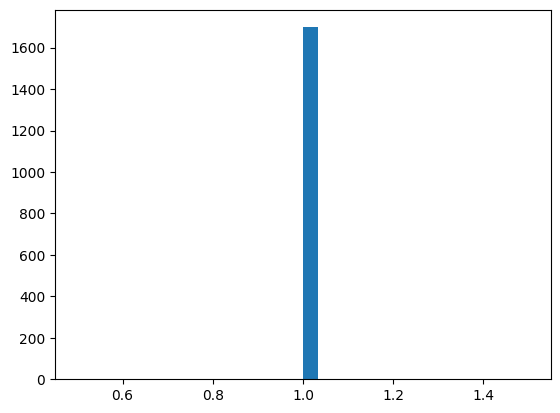

In [42]:
print(sum(scaffold_lengths[-1698:]))

plt.hist(scaffold_lengths[-1698:], bins=30)
plt.show()

1696


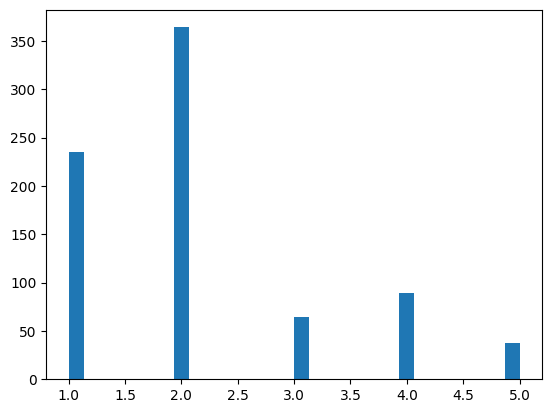

In [48]:
print(sum(scaffold_lengths[-2487:-1698]))

plt.hist(scaffold_lengths[-2487:-1698], bins=30)
plt.show()

13584


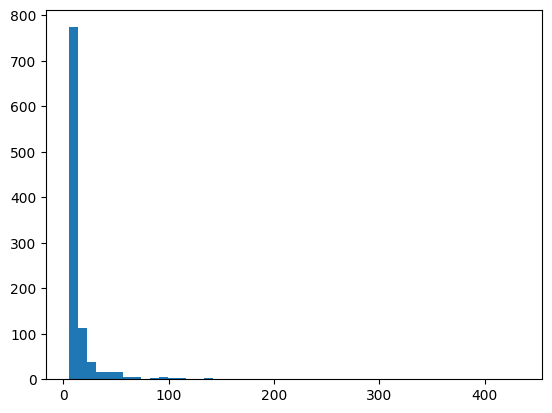

In [61]:
print(sum(scaffold_lengths[:-2487]))

plt.hist(scaffold_lengths[:-2487], bins=50)
plt.show()

In [53]:
frac_train = 0.8
frac_valid = 0.1
frac_test = 0.1

In [56]:
train_cutoff = frac_train * len(datamodule.dataset)
valid_cutoff = (frac_train + frac_valid) * len(datamodule.dataset)

train_inds = []
valid_inds = []
test_inds = []

num_scaffolds_train = 0
num_scaffolds_val = 0
num_scaffolds_test = 0

for scaffold_set in scaffold_sets:
    if len(train_inds) + len(scaffold_set) > train_cutoff:
        if len(train_inds) + len(valid_inds) + len(
                scaffold_set) > valid_cutoff:
            test_inds += scaffold_set
            num_scaffolds_test += 1
        else:
            valid_inds += scaffold_set
            num_scaffolds_val += 1
    else:
        train_inds += scaffold_set
        num_scaffolds_train += 1

In [58]:
num_scaffolds_train, num_scaffolds_val, num_scaffolds_test

(996, 789, 1698)